In [1]:
# !pip install folium
# !pip install missingno

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import ipywidgets as widgets
from ipywidgets import interact, interactive, fixed, interact_manual
from IPython.display import clear_output
import missingno as msno
import seaborn as sns
import folium
from folium import plugins
import json
import requests

pd.options.display.max_columns = 1000

FIGSIZE=np.array([10, 5])

In [2]:
data_path = '..'
data1 = pd.read_csv(data_path + '/Crime_Data_from_2010_to_2019.csv')
data2 = pd.read_csv(data_path + '/Crime_Data_from_2020_to_Present.csv')

police_stations = pd.read_csv(data_path + '/LAPD_Police_Stations.csv')
sheriff_stations = pd.read_csv(data_path + '/Sheriff_and_Police_Stations.csv')
sheriff_stations = sheriff_stations[sheriff_stations['cat3'] == 'Sheriff Stations']

In [3]:
police_stations['cat3'] = 'Police Stations'
sheriff_stations = sheriff_stations[['X', 'Y', 'cat3']]
law_enforcement_df = police_stations.append(sheriff_stations)

### Preprocess the dataframe for easy reference later

In [4]:
def format_mil_string(x):
    """ format_mil_string - format military time integer to a 'HH:MM'
                            string.
    @param x: integer between 0-2359.
    @return string of format 'HH:MM'
    """
    x = str(x).zfill(4) # left pad if less than 4 digits
    minutes = x[-2:]
    if len(x) == 3:
        hour = x[:1]
    else:
        hour = x[:2]
    return hour + ':' + minutes

data1.rename(columns={'AREA ':'AREA'}, inplace=True)
crime_data = data1.append(data2)

crime_data['Date Rptd'] = pd.to_datetime(crime_data['Date Rptd'])
crime_data['DATE OCC'] = pd.to_datetime(crime_data['DATE OCC'])
crime_data['TIME OCC'] = pd.to_datetime(crime_data['TIME OCC'].apply(format_mil_string), format='%H:%M').dt.time

### Categorize different crime codes by their descriptions for easy grouping later

In [24]:
def create_crime_group_df(df, value):
    """ get_codes_from_desc - extract the list of codes whose description matches
                                the substring of the regular expression.
    @param df - dataframe with column 'Crm Cd Desc'
    @param value - string that can be used as a regular expression.
    @return df - a dataframe with columns ['Crm Cd', 'Crm Cd Desc'] where
                 each row crime description matches the regex 'value'.
    """
    # surround value in a regular expression so we can use it as a substring
    regex = rf'.*{value}.*' 
    df = df[df['Crm Cd Desc'].str.match(regex)==True].reset_index()
    return df

def get_crime_subset(df, value, crime_dict):
    """ get_crime_subset - Filter the dataframe to only have the records matching 
                            specific crime codes.
    @param df - dataframe with column 'Crm Cd Desc'
    @param value - string of category of crime requested.
    @param crime_dict - dictionary of crimes {crime_category: dataframe of crime 
                                                                codes in that category}
    @return df - crime dataframe where each row has crime codes in the 
                 crime_dict[value] dataframe.
    """
    crimes_subset_mask = df['Crm Cd'].isin(crime_dict[value]['Crm Cd'])
    return df[crimes_subset_mask]

# get a df of unique (crime codes, crime description) pairs
crime_codes = crime_data[['Crm Cd', 'Crm Cd Desc']].groupby(['Crm Cd', 'Crm Cd Desc'])\
                                                   .first()\
                                                   .reset_index()

# map general crime types to regex descriptions
crime_desc_map = {
            'ANIMAL_CRIME': 'ANIMALS.*|.*BEASTIALITY',
            'ASSAULT': 'ASSAULT',
            'BURGLARY': 'BURGLARY.*|.*PROWLER.*|.*SHOPLIFTING',
            'DISRUPTION': 'DISTURB.*|.*FAILURE TO DISPERSE.*|.*DISRUPT'+\
                            '.*|.*BLOCKING DOOR INDUCTION CENTER',
            'MINOR_UNDERAGE': 'CHILD.*|.*CHLD.*|.*DRUGS, TO A MINOR',
            'WEAPON': 'SHOTS FIRED.*|.*FIREARM.*|.*WEAPON',
            'FRAUD': 'EXTORTION.*|.*BRIBERY.*|.*FALSE POLICE REPORT.*|.*FRAUD'+\
                            '.*|.*COUNTERFEIT.*|.*UNAUTHORIZED.*|.*BUNCO',
            'HOMICIDE': 'HOMICIDE.*|.*MANSLAUGHTER',
            'KIDNAPPING': 'FALSE IMPRISONMENT.*|.*KIDNAP.*|.*HUMAN TRAFFICKING'+\
                            '.*|.*CHILD STEALING',
            'ROBBERY': 'ROBBERY.*|.*PURSE SNATCHING.*|.*PICKPOCKET.*|.*DRUNK ROLL',
            'SEXUAL_CRIME': 'RAPE.*|.*LEWD.*|.*ABORTION.*|.*PEEPING TOM'+\
                            '.*|.*ORAL COPULATION.*|.*PIMPING.*|.*SEX'+\
                            '.*|.*INDECENT EXPOSURE.*|.*PANDERING.*|.*CHILD PORNOGRAPHY',
            'STALKING': 'STALKING.*|.*RESTRAINING ORDER',
            'THEFT': 'THEFT.*|.*STOLEN.*|.*TILL TAP',
            'THREATS': 'THREAT.*|.*BOMB SCARE',
            'VANDALISM': 'DUMPING.*|.*ARSON.*|.*THROWING OBJECT AT MOVING VEHICLE'+\
                            '.*|.*VANDALISM.*|.*TELEPHONE PROPERTY - DAMAGE'+\
                            '.*|.*TRAIN WRECKING.*|.*TRESPASSING',
            'VIOLENT': 'BATTERY.*|.*RESISTING ARREST.*|.*LYNCHING.*|.*INCITING A RIOT',
            'VEHICLE': 'VEHICLE.*|.*DRIVE.*|.*DRIVING.*|.*FAILURE TO YIELD',
            'OTHER': 'MISCELLANEOUS.*|.*CONSPIRACY.*|.*CONTRIBUTING'+\
                            '.*|.*DOCUMENT WORTHLESS.*|.*CONTEMPT OF COURT'+\
                            '.*|.*BIGAMY.*|.*VIOLATION OF COURT ORDER'}

# populate a dictionary {Crime_description: crime_code_df}
crime_dict = {}
for key, value in crime_desc_map.items():
    crime_dict[key] = create_crime_group_df(crime_codes, value).drop(columns=['index'])

# for internal checking on what crime_dict holds
#print(crime_dict['DISRUPTION'])

<AxesSubplot:>

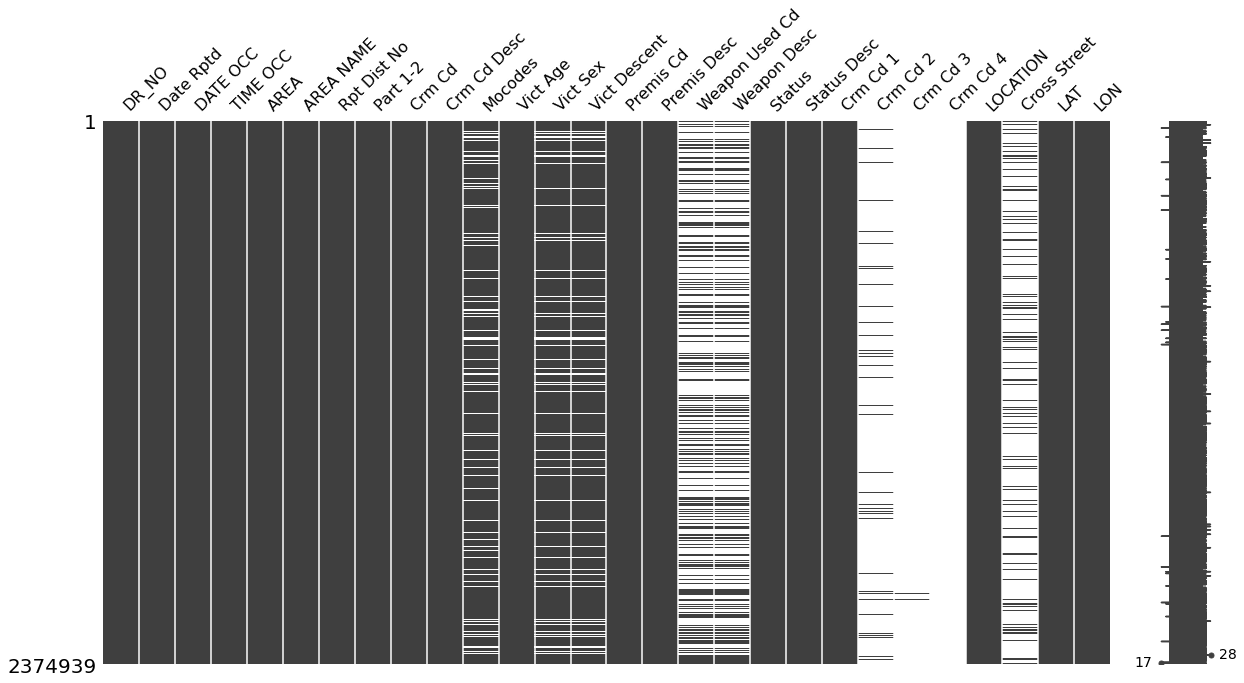

In [25]:
msno.matrix(crime_data, figsize=2*FIGSIZE)

# What is the trend of overall crime in Los Angeles?

In [26]:
def trim_df(df, column, cutoff):
    """ trim_df - Takes a dataframe grouped by some time frame and trims off
                  the last value if it's incomplete (if last date is not the 
                  latest available date).
    @param df - dataframe containing a datetime column 'column'
    @param column - the name of the datetime columnn
    @param cutoff - the latest available date in our crime data (in datetime 
                    format)
    @ return trimmed_df - dataframe of the same format as df.
    """
    end = df[column].tolist()[-1]
    # check if complete
    if (end - cutoff).days != 0:
        # drop end data
        trimmed_df = df[df[column] != end]
    return trimmed_df

In [27]:
latest_date = crime_data['DATE OCC'].max()

biannual_count_by_area = crime_data.groupby(['AREA', pd.Grouper(key='DATE OCC',
                                                                freq='3M', 
                                                                closed='left')])\
                                   .size()\
                                   .reset_index()

# drop the latest date range if incomplete
biannual_count_by_area = trim_df(biannual_count_by_area,
                                 'DATE OCC',
                                 latest_date)
biannual_count_by_area_indexed = biannual_count_by_area.set_index(['AREA', 'DATE OCC'])[0]

# create a map from the area number to the area name
area_df = crime_data.groupby(['AREA','AREA NAME'])\
                    .first()\
                    .reset_index()[['AREA', 'AREA NAME']]\
                    .set_index('AREA')
area_dict = area_df.to_dict()['AREA NAME']

#print(area_dict)
#print(biannual_count_by_area)

In [28]:
def plot_area_range(start, end, area_df, area_dict):
    fig = plt.figure(figsize=FIGSIZE)
    for i in range(start, end):
        plt.plot(area_df[i], label=area_dict[i])
    plt.legend()
    plt.xticks(rotation=70)
    plt.show()

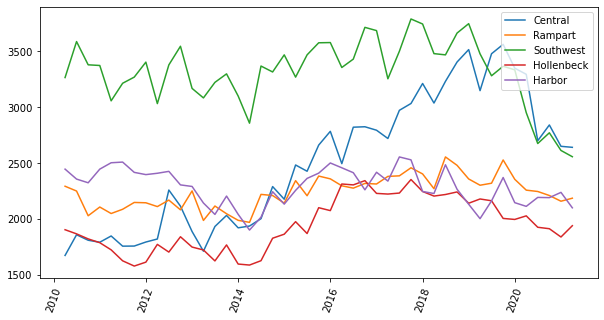

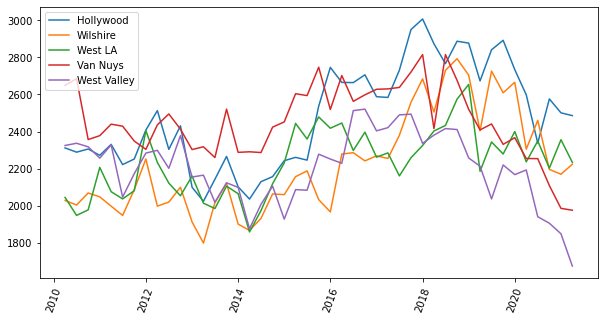

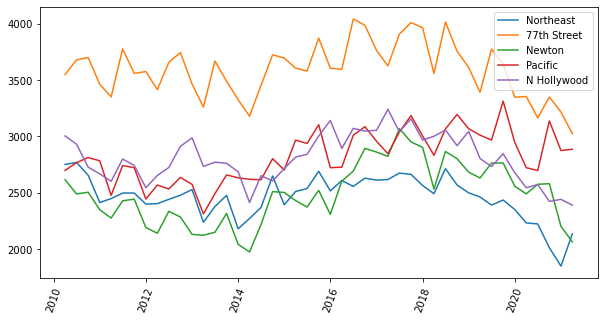

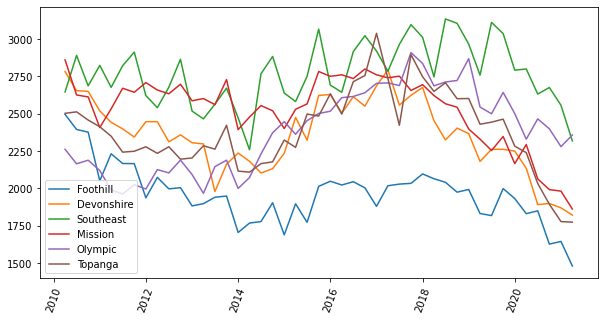

In [29]:
# plot the crime counts corresponding to each of the 21 police departments
plot_area_range(1, 6, biannual_count_by_area_indexed, area_dict)
plot_area_range(6, 11, biannual_count_by_area_indexed, area_dict)
plot_area_range(11, 16, biannual_count_by_area_indexed, area_dict)
plot_area_range(16, 22, biannual_count_by_area_indexed, area_dict)

In [30]:
link = 'https://raw.githubusercontent.com/ritvikmath/StarbucksStoreScraping/master/laMap.geojson'
f = requests.get(link)

la_area = f.text

In [31]:
def plot_map(crime_label, police_stations_df, num_records, police, sheriff=False, year=0):
    """ plot_map - Plots a sample of the locations of the crime type (red) as well as 
                   the locations of the police departments (blue).
    @param crime_label - category of crime to plot. String type.
    @param police_stations_df - dataframe of police department locations (LAT/LON).
    @param police - boolean on whether to show police stations or not
    @param sheriff - boolean on whether to show sheriff stations or not
    @param num_records - a sample of the total data to read plot (Suggested <= 10K).
    @param year
    """
    
    laMap = folium.Map(location=[34.0522,-118.2437], tiles='Stamen Toner', zoom_start=9)
    # use the two lines below instead if we want to scale the map
    #f = folium.Figure(width=1250, height=750)
    #laMap = folium.Map(location=[34.0522,-118.2437], tiles='Stamen Toner', zoom_start=9).add_to(f)

    # year is by far the best filter for reducing records. Do this first to make the dataframe much smaller
    # if a specific year is requested, filter for only that year
    if year > 0:
        year_mask = crime_data['DATE OCC'].dt.year.astype(int) == year
        year_subset_df = crime_data[year_mask]

    # get only the crime records associated with this category of crime
    crime_subset_df = get_crime_subset(year_subset_df, crime_label, crime_dict)
    
    # avoid plotting invalid records
    valid_records_mask = pd.eval('crime_subset_df.LAT != 0 & crime_subset_df.LON != 0')
    crime_subset_df = crime_subset_df[valid_records_mask]
    
    # due to resource restrictions, sample the data rather than plot all the data
    if len(crime_subset_df) >= num_records:
        crime_subset_df = crime_subset_df.sample(num_records)

    #add the shape of LA County to the map
    folium.GeoJson(la_area).add_to(laMap)

    #for each row in the homicide dataset, plot the corresponding latitude and longitude on the map
    for i,row in crime_subset_df.iterrows():
        folium.CircleMarker((row.LAT,row.LON),
                            radius=2,
                            weight=1, 
                            color='red', 
                            fill_color='red',
                            fill_opacity=.5,
                            prefer_canvas=True).add_to(laMap)
    # for each row in police_stations dataset, plot the corresponding latitude and longitude on the map
    for i,row in law_enforcement_df.iterrows():
        fill='blue'
        # if this coordinate is a police station
        if row['cat3'] == 'Police Stations':
            # do we want to show police stations?
            if police:
                fill = 'blue'
            else:
                continue
        # if this coordinate is a sheriff station
        elif row['cat3'] == 'Sheriff Stations':
            # do we want to show sheriff stations?
            if sheriff:
                fill = 'fuchsia'
            else:
                continue
        # add this coordinate to the map
        folium.CircleMarker((row.Y,row.X),
                        radius=6,
                        weight=3, 
                        fill=True,
                        fill_color=fill,
                        color='white',
                        fill_opacity=1).add_to(laMap)
    # add a heatmap to the plot
    laMap.add_child(plugins.HeatMap(data=crime_subset_df[['LAT', 'LON']].to_numpy(),     
                                    radius=10, 
                                    blur=8))
    


    display(laMap)
    #save the map as an html
    #laMap.save('LA_Crime_Map_'+crime_label+'.html')

In [32]:
N_SAMPLES = 10000

category_list = list(crime_desc_map.keys())
category_list.sort()
years_list = crime_data['DATE OCC'].dt.year.unique().tolist()

def plot_func(category, year, police, sheriff):
    clear_output()
    plot_map(category, police_stations, N_SAMPLES, police, sheriff, year=year)

# dropdown object to let us select type of crime
category_widget = widgets.Dropdown(
    style={'description_width': 'initial'},
    options=category_list,
    value=category_list[0],
    description='Crime category:')
# dropdown object to let us select date
year_widget = widgets.Dropdown(
    style={'description_width': 'initial'},
    options=years_list,
    value=years_list[-1],
    description='Year:')
# dropdown object to let us select type of crime
sheriff_widget = widgets.Dropdown(
    style={'description_width': 'initial'},
    options=[True,False],
    value=False,
    description='Show sheriff departments?')
# dropdown object to let us select date
police_widget = widgets.Dropdown(
    style={'description_width': 'initial'},
    options=[True, False],
    description='Show police departments?')

## Plotting crime by category in Los Angeles
Please use the dropdowns below to select a crime category and year to plot.<br>
Police stations are in <font color='blue'>blue</font> with a white outline.<br>
Crime locations (rounded to the nearest block) are in <font color='red'>red</font>.<br>

### Note:
Due to resource restrictions, a random sample is used. The size can be adjusted in the cell above.<br>
Please wait a few seconds between each new crime category.

In [14]:
i = widgets.interactive(plot_func, category=category_widget, year=year_widget, police=police_widget, sheriff=sheriff_widget)
display(i)

interactive(children=(Dropdown(description='Crime category:', options=('ANIMAL_CRIME', 'ASSAULT', 'BURGLARY', …

It may be surpising to see that there are areas in LA county where there is no crime reported. However, this is due to the fact that not all parts of LA county are under the jurisdiction of the LAPD (the owner of the dataset we are using). In fact: 

"LASD provides general law enforcement services to 42 contract cities"
(https://www.lasd.org/about_us.html)

By default, the graph above hides sheriff stations. But toggling them, shows the missing areas where there are sheriff stations. Note, some areas are under the LASD, but do not have a law enforcement station. While it's not safe to say that the mountains and wildlife areas do not have any crime, they are not under the LASD or LAPD.

# What days of the week do most of the crime occur on?

# What days are the most crime occurred on?

# What are the scenarios most likely for a crime to occur? What people?

# What is the ratio of the population descent that is most likely to be a victim of a crime? 

# ML: What's the probability of being a victim of a crime based on the data?

# What kinds of crimes are increasing/decreasing?

In [36]:
def plot_crimes_by_count(crimes_df, crime_dict, plot_type, grouping='TRIANNUALLY'):
    """ plot_crimes_by_count - plot a dataframe of crimes based on whether
                                those codes can be found in crime_dict. Plot
                                is grouped by date based on 'grouping'.
    @param crimes_df - dataframe with columns ['DATE OCC', 'Crm Cd'] 
    @param crime_dict - dictionary of all the crime types we want to plot.
                        key = crime category string, value = dataframe with
                        column 'Crm Cd'
    @param plot_type - type of plot we want ('Line', 'Hist')
    @param grouping - frequency we want to group by ['Monthly', 'Tri-Annually', 'Bi-Annually', 'Yearly']
    """
    frequency_dict = {'Monthly':'1MS', 'Tri-Annually':'3MS', 'Bi-Annually':'6MS', 'Yearly':'AS'}
    fig = plt.figure(figsize=FIGSIZE)
    for key, value in crime_dict.items():
        # get a subset of the crime based user requested crime type
        crime_by_code = crimes_df[crimes_df['Crm Cd'].isin(value['Crm Cd'])]
        # get counts for each date range in this crime subset
        crime_by_date_code = crime_by_code.groupby([pd.Grouper(key='DATE OCC', 
                                                               freq=frequency_dict[grouping],
                                                               closed='left')]).size()\
                                                                               .reset_index()\
                                                                               .rename(columns={0:'Counts'})
        bins = crime_by_date_code['DATE OCC'].tolist()
        # avoid plotting the last row if that date range is incomplete
        crimes_date_code_trimmed = trim_df(crime_by_date_code,
                                           'DATE OCC',
                                           latest_date)
        if plot_type == 'Line':
            plt.plot(crimes_date_code_trimmed.set_index('DATE OCC'), label=key)
        if plot_type == 'Hist':
            plt.hist(crimes_date_code_trimmed['DATE OCC'],
                     weights=crimes_date_code_trimmed['Counts'],
                     bins=bins,
                     alpha=0.5,
                     align='left',
                     label=key)
        if grouping == 'Monthly':
            bins = bins[0::6] # use every 6th bin to avoid unreadable xticks 
            plt.xticks(bins[:-1], rotation=80)
            plt.tight_layout()
        else:
            plt.xticks(bins[:-1], rotation=80)
        plt.legend()

    plt.grid(True, linestyle='-', linewidth=0.5, zorder=0)
    plt.ylabel('Number of incidents')
    plt.xlabel('Date of incident')
    plt.show()

In [37]:
# get a full list of crime types
category_list = list(crime_desc_map.keys())
category_list.sort()
grouping_list = ['Monthly', 'Tri-Annually', 'Bi-Annually', 'Yearly']

category_w = widgets.SelectMultiple(
    style={'description_width': 'initial'},
    options=category_list,
    value=[],
    rows=len(category_list),
    description='Crime types',
    disabled=False
    )

grouping_w = widgets.Dropdown(
    style={'description_width': 'initial'},
    options=grouping_list,
    value=grouping_list[0],
    description='Frequency:')

plot_type_w = widgets.Dropdown(
    style={'description_width': 'initial'},
    options=['Line', 'Hist'],
    value='Line',
    description='Plot type:')

output1 = widgets.Output()

def call_category_plot(categories, grouping, plot_type):
    crime_list = categories
    output1.clear_output()
    if not crime_list:
        return None
    # create a dictionary subset with the selected crime/crime codes only
    dict_subset = {c: crime_dict[c] for c in crime_list}
    # create a dataframe with the selected crimes only
    subset_df = crime_data.iloc[0:0,:].copy()
    for i in crime_list:
        subset_df = subset_df.append(get_crime_subset(crime_data, i, crime_dict))
    # draw and output
    with output1:
        plot_crimes_by_count(subset_df, dict_subset, plot_type, grouping)

## Plot crime by count and category
Please select crime types to plot.<br>
Multiple types are possible. Hold CTRL and click as many options desired.<br>
Plot is recalculated after each new item selected. Please be patient for larger datasets or if you select many types.<br>
To avoid scaling issues, it's recommended to group crime types based on other crime types with similar counts.

## Suggested groupings (counts based on 3 month grouped data):
HIGH (>3K): Assault, Burglary, Theft, Vehicle<br>
MEDIUM (1K-3K): Vandalism, Violence, Weapon<br>
LOW (100-1K): Fraud, Minor_underage, Other, Robbery, Sexual_Crime, Stalking, Threats<br>
VERY_LOW (<100): Animal_Crime, Disruption, Homicide, Kidnapping<br>

In [38]:
j = widgets.interactive(call_category_plot, categories=category_w, grouping=grouping_w, plot_type=plot_type_w)
display(j)
display(output1)

interactive(children=(SelectMultiple(description='Crime types', options=('ANIMAL_CRIME', 'ASSAULT', 'BURGLARY'…

Output()

Using the graph above, we can see trends of particular crime categories over the last 10-11 years. Perhaps most interesting is the the start of the Coronavirus pandemic (March 2020). If we take a look at these categories in the triannual and biannual lenses, we can see trends. Monthly frequency is too granular and annual is too broad.<br><br>

Here we can see the following crime trends:<br>

Decreasing:
+ Burglary
+ Assault
+ Fraud
+ Minor_underage
+ Robbery
+ Sexual_crime
+ Theft
+ Violent


Increasing:
+ Weapon (related)
+ Homicide
<br><br>

It makes sense that overall crime would be dropping, since people are out less, and that creates less opportunity for most crimes. In particular, burglary is down. Again, as people are home more often, there is less opportunity for burglars to strike.<br><br>

Perhaps most surprising is that weapon related and homicide crimes are up. We can only speculate as to the cause, but perhaps it would have to do with the fact that criminals who commit more serious crimes are less likely to follow coronavirus restrictions. 